# Scraper for The Guardian global newssite

### My initial goal was to write a program to process articles about the war in Ukraine. However, due to unexpected changes in the HTML structure of the website and the recognition of new opportunities, I developed it into a more general project, from which I learned a great deal.

In [1]:
### Packages for scraping

from bs4 import BeautifulSoup
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
pd.set_option('display.max_colwidth', None)
import requests
from requests.exceptions import HTTPError
import time

In [2]:
### Packages for the NLP process & visualization of the choosen article

import matplotlib.pyplot as plt
from newspaper import Article
import nltk
nltk.download("punkt")
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Botond\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
### A global df to store the resutl of the scraping

df = pd.DataFrame()

In [4]:
def find_page_by_date(base_url, target_date, max_pages=1357):
    """
    This function takes three inputs: the base URL, which contains the subpages of our targeted articles; 
    the target date, which is the exact day of our interest; and the maximum number of pages to make the 
    searching loop more controllable. The target date has been broken down into days, months, and years 
    to fit with the container's date system. With this formula, we can create container IDs primarily for the daily, 
    and when a daily container does not exist, it leaps to seek out monthly containers. 
    The function sends each page a GET request by means of tick_end; it iterates across pages. 
    If it sends too many requests, that could result in a specific problem: the 429 (Too Many Requests) response. 
    To prevent this, the program had been calibrated to wait a certain time and then retry again. 
    When it finds the container for the given day or (if it is not daily grouped) month, the page's number 
    and the container ID are returned. Otherwise, it returns none.
    """
    
    ## Set the headers to avoid toublesome net protocols
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    
    ## We slice the given date and then adjust it to fit the format of daily and monthly containers
    day, month, year = target_date.split("-")
    container_id = f"container-{day}-{month.lower()}-{year}"
    month_container_id = f"container-{month.lower()}-{year}"

    max_retries = 5
    
    ## This loop forms the heart of the search function, as it allows us to find 
    ## the container of the relevant page with the target date for the corresponding URL
    
    ## Iterate over the pages to find the dedicated container
    for page in range(1, max_pages + 1):
        url = f"{base_url}?page={page}"
        print(f"Requesting URL: {url}")
        
        ## Try to find the page, retrying up to max_retries times if necessary
        for attempt in range(max_retries):
            
            ## This try block attempts to access the specific URL using the get() method
            try:
                response = requests.get(url, headers = headers)
                response.raise_for_status()
                break
            
            ## If the program makes too many requests, 
            ## this section can handle it based on the HTTP error message (429 code)
            ## The delay between requests adapts dynamically to prevent access from being thwarted.
            except HTTPError as HTTP_e:
                if HTTP_e.response.status_code == 429:
                    delay = 1.33 ** attempt
                    print(f"Rate limit warnings. Rest for {delay} seconds...")
                    time.sleep(delay)
                else:
                    raise
                    
        ## If all retries fail this part clarify the situation
        else:
            print(f"Failed to reach the page {page} after {max_retries} attempts.")
            
            return None, False
        
        soup = BeautifulSoup(response.content, "html.parser")
        container = soup.find("div", {"id": container_id})
        
        ## First we check for the daily container
        if container:
            print(f"There is a daily container on page {page}")
            return page, container_id
        container = soup.find("div", {"id": month_container_id})
        
        ## Then we look for  the monthly container's exitsence
        if container:
            print(f"Found monthly container on page {page}")
            return page, month_container_id
        
        ## When there is no fitting container
        else:
            print(f"No container on page {page}")
    
    return None, False

In [5]:
def scrape_articles(url, container_id):
    """
    This function comes right after the find_page_by_date in the chain, 
    and it accepts the result (URL with the correct page number and container ID) as input.
    This will create a GET request on the URL and consume the response using BeautifulSoup.
    As the name suggests, this will find all the articles in the container and unpack their titles,
    respective URLs, and release dates in a table to store them better. 
    We release a daily container or a monthly container on a release date. After the data is created, 
    it is put into a Pandas DataFrame and displayed.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    
    ## Tries to send a GET request to the URL obtained from find_page_by_date
    ## If unsuccessful, raise_for_status() provides information about the request's status and error code
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    
    ## If the request fails, this except block provides context for the failure
    except requests.exceptions.RequestException as req_e:
        print(f"Failed to scrape the page: {req_e}")
        return pd.DataFrame(columns=["title", "url", "release_date"])
    
    ## Based on the previous response, attempts to scrape the content,
    ## if successful, creates a usable soup object
    try:
        soup = BeautifulSoup(response.content, "html.parser")
        container = soup.find("div", {"id": container_id})
        articles = container.select("ul li") if container else []

        ## Handles the HTML structure and selectors for daily containers
        if "daily" in container_id:
            release_date_div = container.find_previous("div", class_="dcr-1atljbz")
            release_date_tag = release_date_div.find("h2") if release_date_div else None
            release_date = release_date_tag.text if release_date_tag else "NaN"
            
        ## Handles the HTML structure and selectors for monthly containers
        else:
            release_date = container_id.split("-")[1].capitalize() + " " + container_id.split("-")[2]

        ## Creates the data list to populate the global dataframe later
        data = []
        
        ## This for loop processes and separates each article within the container,
        ## ensuring the structure matches the daily or monthly container's class arrangement
        for article in articles:
            
            ## Processes titles and article URLs,
            ## enclosed in a try-except block to avoid creating an erroneous dataframe
            try:
                title_tag = article.find("h3", class_="dcr-10yfzki") or article.find("span", class_="dcr-1ay6c8s")
                link_tag = article.find("a", href=True)
                
                title = title_tag.text.strip() if title_tag else "NaN"
                url = link_tag["href"] if link_tag else "NaN"
                
                ## Combines the three pieces of data into the dataframe using the append() method
                data.append({
                    "title": title,
                    "url": f"https://www.theguardian.com{url}",
                    "release_date": release_date
                })
            
            ## Provides an error message if an error occurs while processing an article
            except AttributeError as Attr_e:
                print(f"Error processing article: {Attr_e}")
            
            ## Minimal delay between requests to avoid being blocked due to excessive requests
            time.sleep(0.01)
        
        ## Returns the resulting dataframe
        return pd.DataFrame(data)
    
    ## If an error occurs during processing, prints an error message
    except Exception as exc:
        print(f"An error occurred during scraping: {exc}")
        
        ## Labels the resulting dataframe
        return pd.DataFrame(columns=["title", "url", "release_date"])

### By calling the following cell, any news feed from The Guardian's international edition can be scraped by date. Provide the news feed URRL in the appearing field or follow the format of the examples provided belew, along with a date following the format of the given example.

### A few other examples:

#### *https://www.theguardian.com/society/autism
#### *https://www.theguardian.com/technology/artificialintelligenceai

In [6]:
### Using the capabilities of IPython.display and ipywidgets, this section 
### applies the previously introduced functions to find the page and container corresponding to the input date,
### scrape it according to the presented solution, and load the result into the globally created df dataframe
def on_submit_button_clicked(b):
    base_url = base_url_input.value
    target_date = date_input.value
    page, container_id = find_page_by_date(base_url, target_date)
    
    ## If the page and container are found based on the input values, 
    ## a button appears to display the result
    if page:
        url = f"{base_url}?page={page}"
        global df
        df = scrape_articles(url, container_id)
        print("Articles found. Click 'Show DataFrame' to view the data.")
        show_df_button = widgets.Button(description="Show DataFrame")
        show_df_button.on_click(on_show_df_button_clicked)
        display(show_df_button)
    else:
        print(f"No container for the date: {target_date}")

### This function creates the input interface showing an example value for each field
def on_show_df_button_clicked(b):
    display(df)

## Creates the text field for entering the base URL
base_url_input = widgets.Text(
    value="https://www.theguardian.com/world/ukraine",
    description="Base URL:",
    disabled=False
)

## Creates the text field for entering the date
date_input = widgets.Text(
    value="3-may-2024",
    description="Date:",
    disabled=False
)

## The "Submit" button to initiate the process
submit_button = widgets.Button(description="Submit")
submit_button.on_click(on_submit_button_clicked)

display(base_url_input, date_input, submit_button)

Text(value='https://www.theguardian.com/world/ukraine', description='Base URL:')

Text(value='3-may-2024', description='Date:')

Button(description='Submit', style=ButtonStyle())

Requesting URL: https://www.theguardian.com/world/ukraine?page=1
No container on page 1
Requesting URL: https://www.theguardian.com/world/ukraine?page=2
No container on page 2
Requesting URL: https://www.theguardian.com/world/ukraine?page=3
No container on page 3
Requesting URL: https://www.theguardian.com/world/ukraine?page=4
No container on page 4
Requesting URL: https://www.theguardian.com/world/ukraine?page=5
No container on page 5
Requesting URL: https://www.theguardian.com/world/ukraine?page=6
No container on page 6
Requesting URL: https://www.theguardian.com/world/ukraine?page=7
No container on page 7
Requesting URL: https://www.theguardian.com/world/ukraine?page=8
No container on page 8
Requesting URL: https://www.theguardian.com/world/ukraine?page=9
No container on page 9
Requesting URL: https://www.theguardian.com/world/ukraine?page=10
No container on page 10
Requesting URL: https://www.theguardian.com/world/ukraine?page=11
There is a daily container on page 11
Articles found

Button(description='Show DataFrame', style=ButtonStyle())

,title,url,release_date
0,Ukraine unveils AI-generated foreign ministry spokesperson,https://www.theguardian.com/technology/article/2024/may/03/ukraine-ai-foreign-ministry-spokesperson,3 may
1,Twenty photographs of the weekThe week around the world in 20 pictures,https://www.theguardian.com/artanddesign/gallery/2024/may/03/the-week-around-the-world-in-20-pictures,3 may
2,The Guardian view on Patriarch Kirill’s support for Putin’s war: betraying the faith,https://www.theguardian.com/commentisfree/article/2024/may/03/the-guardian-view-on-patriarch-kirills-support-for-putins-war-betraying-the-faith,3 may
3,Ukraine war liveRussia-Ukraine war: Lithuania hits out at Russia ‘disinformation’ over spy claims – as it happened,https://www.theguardian.com/world/live/2024/may/03/russia-ukraine-war-live-russian-troops-enter-us-base-in-niger,3 may
4,A new cold war? World war three? How do we navigate this age of confusion?,https://www.theguardian.com/commentisfree/article/2024/may/03/cold-war-world-history-future,3 may
5,Ukrainian athletes told to avoid Russians at Olympics in Paris,https://www.theguardian.com/sport/article/2024/may/03/ukraine-russia-athletes-2024-olympic-games-paris,3 may
6,"Ukraine war briefing: Ukrainians ‘have the right to strike inside Russia’, says David Cameron",https://www.theguardian.com/world/article/2024/may/03/ukraine-war-briefing-ukrainians-have-the-right-to-strike-inside-russia-says-david-cameron,3 may


### Choose an article from the scraped links, copy the content from the dataframe into the input field, and you'll get a word cloud and summary of the selected piece.

*******************************************************************************************************************************
Summary of the article: 
_______________________________________________________________________________________________________________________________
From 3 May 2024 15.28 CEST Lithuania hits out at Russia 'disinformation' over spy claims Lisa O'Carroll The Lithuanian government has said there have been “false Russian claims of sabotage planned by a person who allegedly entered to Russia from Lithuania in March”.
Any Western-backed Ukrainian strike against the Crimean bridge or Crimea itself will be met with a powerful revenge strike from Russia, foreign ministry spokeswoman Maria Zakharova said.
Russian defence minister Sergei Shoigu said on Friday that Russian troops had captured 547 sq km of territory in Ukraine this year.
The Russian defence ministry said on Friday that its air defence forces destroyed six drones that Ukraine launched overnight.
Reuters

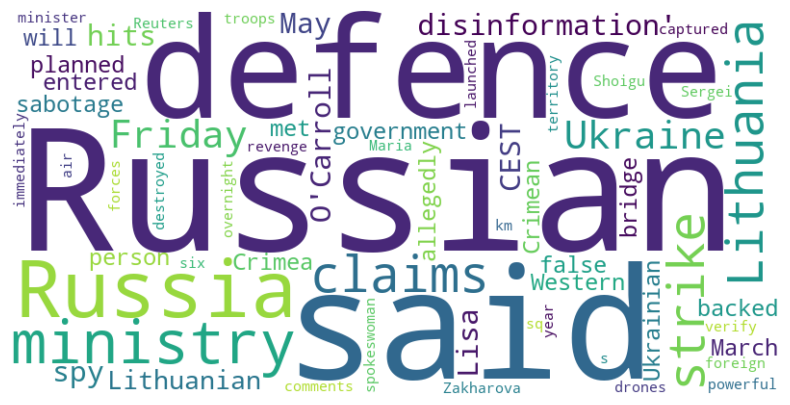

In [8]:
def generate_wordcloud_from_article():
    """
    This function generates a word cloud from the summary of a given article URL.
    It uses the Newspaper3k library to download and process the article, then
    generates a word cloud using the WordCloud library, and displays it.
    """
    
    ## Prompts the user to input the URL of the chosen article
    url = input("Please share the URL of your chosen article: ")
    
    ## Uses the Newspaper3k library to scrape, parse, and utilize NLP methods on the article
    article = Article(url)
    article.download()
    article.parse()
    article.nlp()

    ## Here the program uses NLP methods to summary the articl
    text = article.summary
    print("*******************************************************************************************************************************")
    print("Summary of the article: ")
    print("_______________________________________________________________________________________________________________________________")
    print(text)
    print("_______________________________________________________________________________________________________________________________")
    print("*******************************************************************************************************************************")
    
    ## Generates a word cloud from the article summary
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud_from_article()